In [ ]:
#Facial Recognition using face_recognition library
#training images in 'D:\nuclei\img\new' directory

In [84]:
import os
BASE_DIR=os.path.dirname(os.path.abspath('img'))
imgs_path=os.path.join(BASE_DIR,'img/new')
list_path=[]
labels=[]
for root, dirs, files in os.walk(imgs_path):
    for img in files:
        path=os.path.join(root, img)
        label=os.path.basename(path)
        labels.append(label[:-4])
        list_path.append(path)
print(labels)

['Chris Evans', 'Chris Hemmsworth', 'Donald', 'Dwayne', 'Mark Ruffalo', 'Paul Rudd', 'Robert Downey Jr', 'Scarlet Johansson']


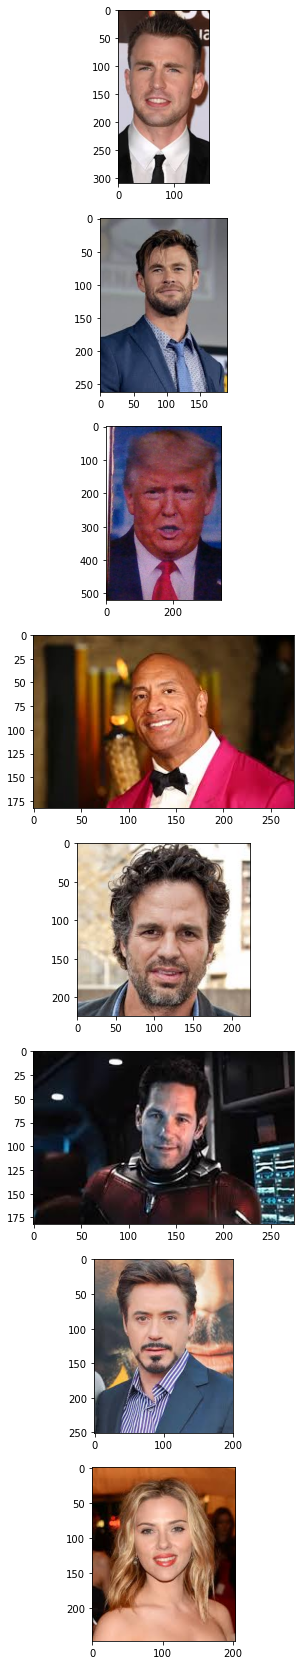

In [98]:
import face_recognition
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
import cv2
%matplotlib inline

fig=plt.figure(figsize=(30,30))
c=1
r=len(list_path)
cnt=0
for path in list_path:
    cnt+=1
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig.add_subplot(r,c,cnt)
    plt.imshow(img)
plt.show()

In [86]:
list_train_encodings=[]
for path in list_path:
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    list_train_encodings.append(face_recognition.face_encodings(img)[0])

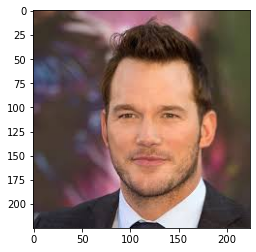

In [107]:
unknown_img=cv2.imread('img/4.jpg')
unknown_img=cv2.cvtColor(unknown_img, cv2.COLOR_BGR2RGB)
plt.imshow(unknown_img)

unknown_face_encod=face_recognition.face_encodings(unknown_img)

In [108]:
from scipy.spatial import distance

for ufe in unknown_face_encod:
    result=[]
    for train_encod in list_train_encodings:
        d=distance.euclidean(train_encod,ufe)
        result.append(d)
    thresh=0.6
    f_result=np.array(result)<=thresh
    name='unknown'
for i in range(0,len(f_result)):
    if f_result[i]== True:
        name=labels[i]
print("The given image is of",name)

The given image is of unknown


In [91]:
#Also used another approach
#face recognition using LBPHFaceRecognizer and harrcascade
#but this classifer did not return accurate results

In [ ]:
import cv2
import os
from PIL import Image
import numpy as np
import pickle

face_cascade=cv2.CascadeClassifier('D:/nuclei/data/haarcascade_frontalface_alt2.xml')
recognize=cv2.face.LBPHFaceRecognizer_create()

cnt=0
label_dict={}
x_train=[]
y_labels=[]

BASE_DIR=os.path.dirname(os.path.abspath('nuclei'))
img_dir=os.path.join(BASE_DIR, 'img')

for root, dirs, files in os.walk(img_dir):
	for img in files:
		if img.endswith('png') or img.endswith('jpg'):
			path=os.path.join(root, img)
			label=os.path.basename(root).replace(" ","-").lower()
			#print(path)
			if not label in label_dict:
				label_dict[label]=cnt
				#print(cnt)
				cnt+=1
			curr_id=label_dict[label]
			#print(curr_id)
			pil_img=Image.open(path).convert('L')   #convert to grayscale
			size=(650,650)
			f_img=pil_img.resize(size, Image.ANTIALIAS)
			img_arr=np.array(f_img,'uint8')
			#print('k')
			#print(img_arr)
			faces=face_cascade.detectMultiScale(img_arr, scaleFactor=1.1, minNeighbors=2)
			#print(faces)
			for (x,y,w,h) in faces:
				roi=img_arr[x:x+w,y:y+h]
				x_train.append(roi)
				y_labels.append(curr_id)
print(y_labels)
with open("labels.pickle",'wb') as f:
	pickle.dump(label_dict,f)

recognize.train(x_train,np.array(y_labels))
recognize.save("train.yml")

In [ ]:
import cv2
import numpy as np
import pickle

face_cascade=cv2.CascadeClassifier('D:/nuclei/data/haarcascade_frontalface_alt2.xml')
recognize=cv2.face.LBPHFaceRecognizer_create()
recognize.read('train.yml')

labels={}
with open("labels.pickle",'rb') as f:
	old_labels=pickle.load(f)
	labels={v:k for k,v in old_labels.items()}
cap=cv2.VideoCapture(0)

while(True):
	ret,frame=cap.read()
	gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
	faces=face_cascade.detectMultiScale(gray, scaleFactor=1.5,minNeighbors=5)
	for (x,y,w,h) in faces:
		roi=gray[x:x+w,y:y+h]
		curr_id, conf=recognize.predict(roi)
		print(conf)
		if conf>=30 and conf<=200:
			print(curr_id,'  ',labels[curr_id])
			font=cv2.FONT_HERSHEY_SIMPLEX
			name=labels[curr_id]
			color=(255,255,255)
			stroke=2
			cv2.putText(frame, name, (x,y), font, 1, color, stroke, cv2.LINE_AA)
		color=(0,255,0)
		stroke=2
		cv2.rectangle(frame, (x,y), (x+w,y+h), color, stroke)

	cv2.imshow('frame',frame)
	if cv2.waitKey(20) & 0xFF == ord('e'):
		break

cap.release()
cv2.destroyAllWindows()